# IMPORTS

In [2]:
import os
import time
import warnings

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint

from nltk.corpus import stopwords

from scipy.sparse import csr_array

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# CONFIGURATION

In [110]:
# PREVIEW PHASE
PREVIEW_SIZE = 1000

# EXTRACT PHASE
CHUNK_SIZE = 10000
EXTRACT_PARQUET = True

# SAMPLINg
SAMPLING_SIZE = 1000

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
PREFIX_YELP = 'yelp_academic_dataset_'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set()

# FONCTIONS

In [124]:
def time_from(time_start):
    time_total = round(time.time() - time_start, 0)
    minutes = time_total // 60
    seconds = time_total - minutes * 60
    return f'{minutes:.0f}mn {seconds:.0f}s'
    
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df    

def get_stop_words(reviews: pd.DataFrame, min_df = 1, max_df = 0, verbose = 0):
    words = {}
    for index in reviews.index:
        for token in reviews.loc[index, 'tokens']:
            if token not in words:
                words[token] = 1
            else:
                words[token] = words[token] + 1

    words = dict(sorted(words.items(), key=lambda item: item[1]))

    # Remove english stop word
    english_sw = stopwords.words('english')
    words_wo_sw = {token:words[token] for counter, token in enumerate(words) if token not in english_sw}

    # Drop most frequent
    most_frequent = [[token, words_wo_sw[token]] for counter,token in enumerate(words_wo_sw) if counter > len(words_wo_sw) - max_df - 1]
    if verbose > 1 : 
        print(f'Les {max_df} mots les plus fréquents:')
        print(tabulate(most_frequent[::-1], headers=['mot', 'Nombre d\'apparitions']))
        print('')

    # Drop frequency under
    frequency_under = [token for token, count in words_wo_sw.items() if count < min_df]
    if verbose > 1:
        print(f'{len(frequency_under)} mots apparaissent moins de {min_df} fois:')
        np_treshold = np.get_printoptions()['threshold']
        np.set_printoptions(threshold=20)
        print(np.array(frequency_under))
        np.set_printoptions(threshold=np_treshold)
        print('')

    sw = list(set(stopwords.words('english') + list(np.array(most_frequent).T[0]) + frequency_under))

    return sw, len(words)      

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    return tokens

def word_cloud(text):
    wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

def get_vocabulary_matrix(reviews: pd.DataFrame):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for review in list(reviews['tokens']):
        for token in review:
            index = vocabulary.setdefault(token, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    csr = csr_array((data, indices, indptr), dtype=int).toarray()

    return csr

def lda(reviews: pd.DataFrame, n_topics = 10, n_top_words = 10, verbose = 0):
    if verbose > 1: print('  - Creation de la matrice du vocabulaire')
    vocabulary_matrix = get_vocabulary_matrix(reviews)

    # Topics from LDA
    if verbose > 1: print('  - Modélisation LDA')
    model_lda = LatentDirichletAllocation(
            n_components=n_topics, 
            max_iter=5, 
            learning_method='online', 
            learning_offset=50.,
            random_state=0,
            n_jobs=-1)
    model_lda.fit(vocabulary_matrix)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    feature_names = list(set(reviews['tokens'].sum()))
    for topic_idx, topic in enumerate(model_lda.components_):
        features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    return topics

def tf_idf():
    tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=sw)
    values = tfidf.fit_transform(token_dict.values())

# PREVISUALISATION DES DATASETS

In [5]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [6]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
175,JnbSkfsl_j2dUoHncBTonA,Collision XS,1416 Centreville Ave,Belleville,IL,62220,38.502279,-90.006170,4.5,6,1,"{'WiFi': 'u'free'', 'BusinessAcceptsCreditCard...","Auto Repair, Body Shops, Automotive","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
33,kV_Q1oqis8Qli8dUoGpTyQ,Ardmore Pizza,10 Rittenhouse Pl,Ardmore,PA,19003,40.006707,-75.289671,3.5,109,1,"{'RestaurantsGoodForGroups': 'True', 'WiFi': '...","Pizza, Restaurants","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ..."
71,B2qqjCl_BNNnXvWWfpFiLA,Pottery Barn Kids,"4011 Hillsboro Pike, Ste 102",Nashville,TN,37215,36.103614,-86.816268,1.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Shopping, Baby Gear & Furniture, Home Decor, F...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-20:0', ..."
111,H0NEOp4e3Zu598u6kO3y0g,America's Best Contacts & Eyeglasses,"79 Route 73, Ste 6, Coopers Plaza",Voorhees,NJ,08043,39.824552,-74.929032,3.5,17,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Eyewear & Opticians, Health & Medical, Shoppin...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-18:0', '..."
985,iIJDIIUVmcvFUZrgnj983g,Sierra Car Wash,4991 Longley Ln,Reno,NV,89502,39.478089,-119.764921,3.0,109,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Automotive, Car Wash","{'Monday': '7:30-18:0', 'Tuesday': '7:30-18:0'..."


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



,business_id,date
994,-TcixRtn5X3s9UUcs0lYvA,"2015-04-17 22:36:03, 2015-04-18 20:55:27, 2015..."
176,-42jRI5dhpbubYReeXPK2A,"2015-08-25 15:36:50, 2015-08-28 16:06:45, 2016..."
50,-0TffRSXXIlBYVbb5AwfTg,"2013-05-31 23:03:18, 2013-05-31 23:05:01, 2013..."
808,-OX0MJDPRHV0RCRvwYnvBQ,"2020-02-02 03:45:39, 2020-02-02 22:37:59, 2020..."
945,-SQjHJMSDQFKjSo_La5srQ,"2016-12-10 18:13:13, 2018-09-01 20:07:58"


business_id    object
date           object
dtype: object


PREVIEW review



,review_id,user_id,business_id,stars,useful,funny,cool,text,date
244,J4bewYavb3HEhYkEOc3QFQ,6n4rordXMXornGniNGppkQ,ehnMcJZlx29XMroxMd3-mQ,4,1,0,1,Spice n Grill has the best Indian food in St. ...,2013-12-29 18:26:30
205,sOIEFZMEzb055tCO_tBSvQ,1xS8Jj23zHx8axIVopG3wA,W4ZEKkva9HpAdZG88juwyQ,4,0,0,0,Excellent. Went there for lunch (the budget o...,2011-01-09 03:52:09
238,xqp0pnO0PfBkaFRNaVImYw,c35f8FumQy5045zFbIir6w,_uyLoz0BbrQIVmUEm_td1Q,3,0,0,0,My husband had the 6 oz pepperloin meal and wa...,2018-06-09 01:10:44
127,940tqxFO4Pwg_KMg4Y4Z5g,O6wkgoJqU7KMjleSlCDGaA,EQ-TZ2eeD_E0BHuvoaeG5Q,5,2,0,1,Milktooth is the place to go if you want a goo...,2018-01-10 01:48:58
188,NvusujU9_5pIUbn9SZ6hMA,nbVYXmDUO6XH-wvhY62uvg,XMGjDIAFbu9VSmWDs-Ev5w,4,0,0,0,Stopped by to munch a burger during today's Se...,2011-01-08 23:52:22


review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



,user_id,business_id,text,date,compliment_count
529,2hMwI_rbESY9-79RWJMx7w,YrNtBUOUOYwmRZ_UVwH8iQ,"Eggs ""Rose""",2011-05-09 18:10:39,0
83,Ig2ttf1xX2Ihlm0nsykaTw,uZsStnH9w2xY15og9VsQZA,The staff is so nice sometimes you get hugs:),2013-05-24 18:52:05,0
984,rwur9LLbVxUYQ3a8sx8WwQ,CJoO4HYD0tZRXlZqA04wmw,"Easy parking,nice alternative to 4th St and Un...",2011-10-08 23:22:36,0
261,_YqknhseJ6yjtS1g0D4Vwg,TZG_XV9u4xgE56s0otXEag,Huge menu like cheesecake factory. Beer not s...,2015-02-10 17:59:56,0
510,Sb-ilkkBbvc2JE9DVTfuUQ,-EHrU_DwtX2Jv4NbAMppTA,Do not come here for a QUICK lunch. 25 minutes...,2014-09-03 17:03:21,0


user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
535,eAA9CmVmPIRewS7l6l7xbw,Rebecca,80,2010-05-27 15:28:59,130,80,95,"2015,2016","zTE3DQYmnXzTnrownpsXZQ, rEoLQR967yCy1NusQ4UQrg...",8,...,1,0,0,0,4,9,3,3,6,0
971,mxnis1VG5Y3_h-fNKjtX-g,Brad,50,2010-05-12 20:06:57,104,8,39,"2012,2013,2014","9UrlwLv36LB3zV8lUtxdzg, 2CCJdupLxjqxthneSuuScQ...",5,...,1,1,0,0,4,9,19,19,6,0
392,jfWSPWnGjSLHGMz0CNIZtw,Steve,55,2010-07-17 20:37:25,50,21,11,,"HxnOsVI1RPLIwo2MPdCjTg, fVcdur3u2KqV0JcA3-Lo6Q...",5,...,0,0,0,0,0,1,2,2,1,0
547,0MeivhX0kZCfV3zMtHtk9Q,Charles,897,2009-01-11 04:34:11,3214,1491,1891,"2010,2011,2012,2013,2014,2015,2016,2017,2018,2...","5INJa2npTkjUkX75ptn6WQ, mJCK1qpsCkKePozYIrIT-g...",96,...,19,13,2,8,86,330,152,152,103,3
425,0fKmCIvKlkXwBZU44D0umg,Daniel,320,2011-05-08 07:00:10,797,323,435,"2016,2017,2018,2019,20,20,2021","9yNHQnBNu3SFXYUenOgZTQ, IJ_m5LKvrzW_3GFzCtrqsg...",27,...,0,0,0,0,14,14,7,7,26,5


user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

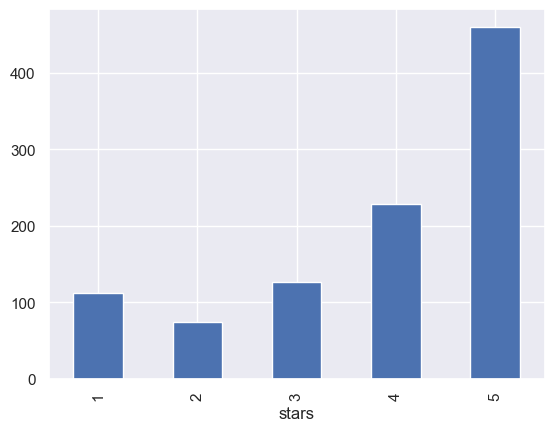

In [7]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [8]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [9]:
review = preview_dfs['review']
for star in range(1,6):
    print(f'Note = {star}:\n=========\n')
    for index in review[review['stars']==star].sample(4, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        print(f'{text}\n\n')

Note = 1:

They have the WORST service advisors! Used to be good before Kelly and her team left. Unfortunately, it's convenient to work if I need oil change before I can make it to another Honda dealer.


It is unfortunate that with such a unique location and such a brand and product offering this specific store offers such lousy service. The wait is endless, no one is available to help and at Christmas time getting a gift wrap is act of God that requires endless wait. I bought gifts and knew that the wait for wrapping would be long SO I even left my items at the store to be gift wrapped at their leisure. They were not even moved from the counter where I bought them when I returned almost two hours later ready for pick up. This was a gift that needed to be given and The staff COMPLETELY "dropped the ball" on my time constraints! 

I love their stuff, but today was my last shopping experience at this location: couldn't get a gift wrapped after being assured that it could be done in a ti

<Axes: xlabel='class'>

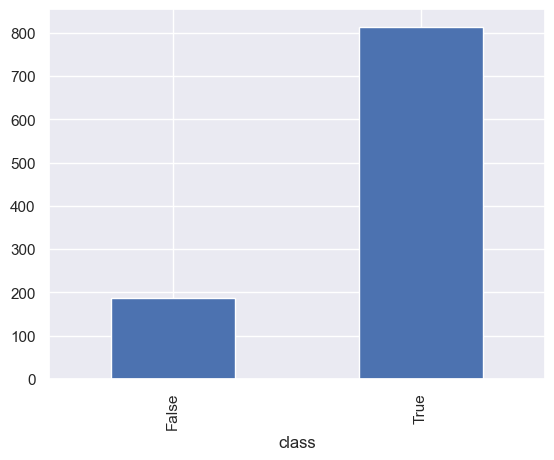

In [10]:
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > 2
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

In [11]:
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]

# EXTRACTION GOOD/BAD REVIEWS DES RESTAURANTS

## CATEGORIES DE BUSINESS

In [12]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

132010    [Food Delivery Services, Food Trucks, Bakeries...
121884    [Pilates, Acupuncture, Fitness & Instruction, ...
85482                         [Pizza, Restaurants, Italian]
52940               [Nightlife, Bars, Mexican, Restaurants]
141257                                   [Pets, Pet Stores]
Name: _cats, dtype: object

In [13]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [14]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Restaurants', 'Pop-Up Restaurants', 'Restaurant Supplies']

In [15]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Imported Food',
 'Seafood Markets',
 'Do-It-Yourself Food',
 'Seafood',
 'Soul Food',
 'Food',
 'Live/Raw Food',
 'Food Trucks',
 'Specialty Food',
 'Food Banks',
 'Food Stands',
 'Food Delivery Services',
 'Fast Food',
 'Food Court',
 'Ethnic Food',
 'Comfort Food',
 'Food Tours']

## REDUCTION DU DATAFRAME REVIEW ET SAUVEGARDE

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation en bad/good reviews (bad <= stars = 3 < good)
- Ne garder que text et séparer en 2 fichiers good/bad news

In [16]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')
restaurants_ids[0:10]

52268 business sont des Restaurants


['MTSW4McQd7CbVtyjqoe9mw',
 'CF33F8-E6oudUQ46HnavjQ',
 'k0hlBqXX-Bt0vf1op7Jr1w',
 'bBDDEgkFA1Otx9Lfe7BZUQ',
 'eEOYSgkmpB90uNA7lDOMRA',
 'il_Ro8jwPlHresjw9EGmBg',
 '0bPLkL0QhhPO5kt1_EXmNQ',
 'MUTTqe8uqyMdBl186RmNeA',
 'ROeacJQwBeh05Rqg7F6TCg',
 'WKMJwqnfZKsAae75RMP6jA']

In [111]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2):
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

# TOKENIZATION ET ANALYSE DES BAD REVIEWS 

## TF-IDF + PCA/TSNE

In [128]:
def tf_idf(reviews, min_df = 4, max_df = 100, tsne_target = None, pca_target = None, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words="english", sublinear_tf=True,ngram_range=(1,2))
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        for index in df.sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[150, None]))

    if tsne_target:
        X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=35).fit_transform(values)
        tsne_df = pd.DataFrame(X_tsne, columns=['x', 'y'])
        tsne_df['hue'] = reviews[tsne_target]
        sns.scatterplot(data=tsne_df, x='x', y='y', hue='hue')
        plt.show()

    if pca_target:
        #scaler = StandardScaler()
        #values_scaled = scaler.fit_transform(values.toarray())
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(values.toarray())
        pca_df = pd.DataFrame(X_pca, columns=['x', 'y'])
        pca_df[pca_target] = reviews[pca_target]
        sns.scatterplot(data=pca_df, x='x', y='y', hue=pca_target, alpha=0.6)
        plt.show()

    return values, vectorizer

Nombre de textes dupliqués supprimés: 0
Il y a 5000 enregistrements

Vecteurs TF-IDF des reviews:


,100,10pm,1st,200,2nd,30pm,3rd,4th,6pm,7pm,...,yesterday,yogurt,york,young,yuck,yum,yummy,zero,zero star,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209111,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


+--------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                                                                            | vecteur tf-idf           |
+========================================================================================================================================================+==========================+
| Co-workers and I placed a big order. The meal in particular was an apple cinnamon pancake with eggs and bacon for $9.99. When made thr fool mistake of | answer: 0.1655           |
| trusting that everything was going to be correct with the order and when we finally opened the bag at work in that order was the pancake.. Can you     | apple: 0.1809            |
| imagine spending $10 on 1 pancake?? Well I called this establishment the following morni

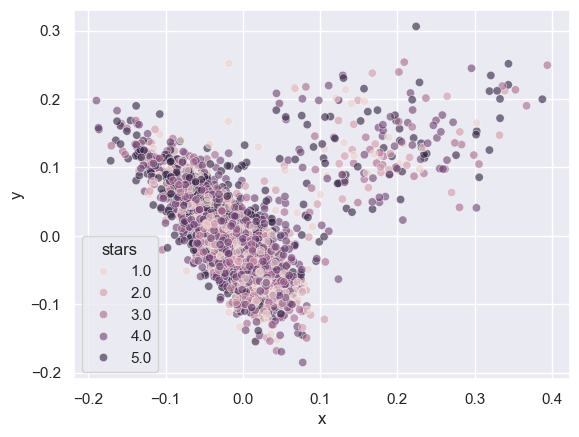

In [129]:
reviews = get_reviews(max_stars=5)
values, vectorizer = tf_idf(reviews=reviews, min_df=10, max_df=0.1, pca_target='stars', verbose=1)

## FINDING TOPICS

In [130]:
def find_topics(reviews, min_df = 4, max_df = 100, n_topics = 10, n_topic_top_words=10, verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 1: 
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)
    
    # Remove words by frequency
    if verbose > 0:
        print(f'\nSuppression par fréquence\n=================')
        print(f'  - {max_df} mots les plus fréquents')
        print(f'  - apparaisant moins de {min_df} fois\n')

    stop_words, nb_words_original = get_stop_words(reviews, min_df, max_df, verbose)
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()
    
    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    if verbose > 1:
        # View result sample
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])
    
        # Calc and view text lengths
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    if verbose > 0:        
        # Text length
        total_text_len = reviews['text_len'].sum()
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
    
        print('')

    if verbose > 1:
        # Visualisation Word clound on sample
        cloud_sample_size = min(reviews.shape[0], 1000)
        print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')
        sample_text = ' '.join(reviews.sample(cloud_sample_size, random_state=0)['tokens'].str.join(' ').values)
        word_cloud(text=sample_text)
        print('')


    if verbose > 0: print('\nRecherche des topics\n=================\n')
    # Create counter matrix from vocabulary
    topics = lda(reviews, n_topics, n_topic_top_words, verbose)

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)
    
    return topics

Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements


,stars,text
index,,
5500,1,"Great food, great drinks, terribly (unapologetically so) service. It's not dick's last resort, it's not your shtick to be shitty... We had to ask for water four times and when we got it, it was luke warm.......annnnnd it wasn't busy. like the vibe would consider coming back for drinks but would..."
3245,2,"Thought that perhaps this would be an excellent place to go to get succulent Florida gulf seafood while watching the playful antics of tropical fish in their famed aquarium. Buzzzzzzz. Wrong. When we entered, we were shuffled over to a seat that was a mile away from the aquarium and told, ""Oh. T..."
2203,2,I'm being generous by giving this restaurant 2 stars. The service was so appalling that the fact that the food was actually ok is this place's only saving grace. I think we saw our waiter a total of 3 times the entire evening. We were never greeted after we were seated. We had to ask the Maitre'...
10328,1,"AVOID THIS LIKE THE PLAUGE!!! I can see why they make money, this place is beautiful, but their customer service is atrocious. As someone in the event planning industry, I will see to it that I never recomend this location to any of my clients and will make sure all my partners and colleges know..."
12406,2,"They kept us waiting and waiting with our three kids without telling us anything. \nBeside that, the food wasn't bad but really nothing exceptional especially for the price!"



Preprocess




Tokenize




Suppression par fréquence
  - 20 mots les plus fréquents
  - apparaisant moins de 2 fois

Les 20 mots les plus fréquents:
mot           Nombre d'apparitions
----------  ----------------------
food                          1818
order                         1671
get                           1438
good                          1267
place                         1224
come                          1012
time                           986
like                           887
service                        886
one                            824
say                            794
back                           756
go                             743
would                          731
take                           720
wait                           678
make                           642
restaurant                     640
ask                            636
table                          630

3455 mots apparaissent moins de 2 fois:
['tipper' 'kanella' 'freebirds' ... 'ben' 'tennis' 'walker']




-------------------------------------------------  ----
Nombre de tokens unique initial dans le dataframe  7900
Nombre de stopwords                                3654
Nombre de tokens unique restant dans le dataframe  4319
-------------------------------------------------  ----

Echantillon du resultat



,stars,tokens
index,,
5500,1,"[great, great, drink, terribly, dick, last, resort, shitty, water, four, luke, warm, busy, vibe, consider, drink, prepare, walk, shit, show]"
3245,2,"[think, perhaps, excellent, succulent, florida, gulf, seafood, watch, tropical, fish, aquarium, wrong, enter, shuffle, seat, mile, away, aquarium, tell, many, people, reservation, expect, afterwards, old, couple, question, seat, close, tank, wrinkly, old, butt, escort, front, center, fine, end, ..."
2203,2,"[generous, give, star, appal, fact, actually, save, grace, think, saw, waiter, total, entire, even, never, greet, seat, maitre, could, water, could, rude, finally, water, water, three, separate, finally, arrive, point, receive, never, saw, waiter, bus, boy, another, glass, wine, never, finally, ..."
10328,1,"[avoid, see, money, beautiful, customer, atrocious, someone, event, plan, industry, see, never, recomend, location, client, sure, partner, college, know, dissapointment, gaylord, opryland, hesitant, even, book, location, due, horrible, review, really, want, lesson, learn, hard, way, never, life,..."
12406,2,"[keep, three, kid, without, tell, anything, beside, bad, really, nothing, exceptional, especially, price]"



Analyse des longeurs de text



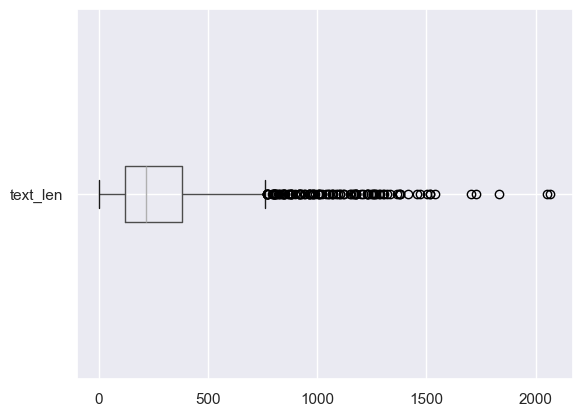

Longeur total du texte dans le dataframe: 585765


Visualisation du nuage de mot d'un échantillon de 1000 lignes



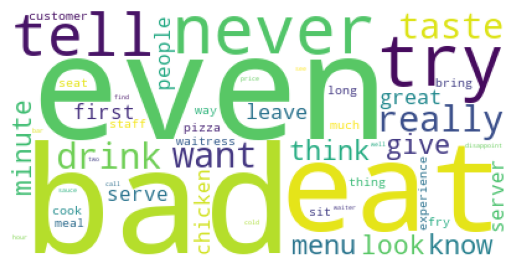



Recherche des topics

  - Creation de la matrice du vocabulaire
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  -------------------------------------------
         0  greatly, spanish, cafe, network, price
         1  1pm, msg, gossip, everyone, kind
         2  allergic, diet, inaudible, alcoholic, comfy
         3  respect, sriracha, dang, happy, mac
         4  decrease, poorly, happy, converse, mom


In [131]:
topics = find_topics(reviews=get_reviews(max_stars=2),
                     min_df=2,
                     max_df=20,
                     n_topics=5, 
                     n_topic_top_words=5,
                     verbose=3)

In [132]:
import pyldavis
pyldavis.

ModuleNotFoundError: No module named 'pyldavis'

In [41]:
topics_grid = []
start = time.time()
LINE_UP = '\033[1A'
LINE_CLEAR = '\x1b[2K'

min_df_range = range(2,11,3)
max_df_range = range(10, 101, 25)
n_topics_range = range(3,8,2)

total_loops = len(min_df_range)*len(max_df_range) * len(n_topics_range)
current_loop = 1
for min_df in min_df_range:
    for max_df in max_df_range:
        for n_topics in n_topics_range:
            print(f'Recherche {current_loop}/{total_loops}')
            print(f'Temps écoulé {time_from(start)}')
            print(f'Parametres:')
            hyper_params = [['Fréquence minimal d\'un mot', min_df], ['Top des mots les plus fréquent supprimés', max_df], ['Nombre de topics', n_topics]]
            print(tabulate(hyper_params,))
            topics = find_topics(reviews_file=bad_reviews_file,
                                              min_df=min_df,
                                              max_df=max_df,
                                              n_topics=n_topics, 
                                              n_topic_top_words=5,
                                              sample_size = 100,
                                              verbose=0)
            current_loop = current_loop + 1
            clear_output()
            topics_grid.append({'params': 'min_df\nmax_df' ,
                                'value': str(min_df) + '\n' + str(max_df),
                                'topics': '\n'.join([str(topic[0]) + ' : ' + topic[1] for topic in topics])
                               })

print(f'{total_loops} boucles éxécutées en {time_from(start)}\n\n')
print(tabulate(topics_grid,  headers="keys", tablefmt="grid"))
        

36 boucles éxécutées en 8mn 59s


+----------------------------+---------+-----------------------------------------------------+
| params                     | value   | topics                                              |
+============================+=========+=====================================================+
| drop_words_frequency_under | 2       | 0 : poor, someone, irritate, friend, build          |
| drop_most_frequent_words   | 10      | 1 : sauce, inside, sunday, well, busy               |
|                            |         | 2 : mess, literally, girl, busy, mediocre           |
+----------------------------+---------+-----------------------------------------------------+
| drop_words_frequency_under | 2       | 0 : poor, another, southern, sit, build             |
| drop_most_frequent_words   | 10      | 1 : inside, mediocre, sunday, replacement, probably |
|                            |         | 2 : girl, literally, mess, mediocre, try            |
|               